<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter4GeometricImaging/projectionTomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projection Tomography
###David Brady
### University of Arizona

Section 4.3 of **Computational Optical Imaging**

### Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp, iradon
from scipy import interpolate
from skimage.transform import iradon_sart


### load mnist data set as example images

In [2]:
from keras.datasets import mnist
# load the mnist dataset of characters
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Sinograms of various images

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


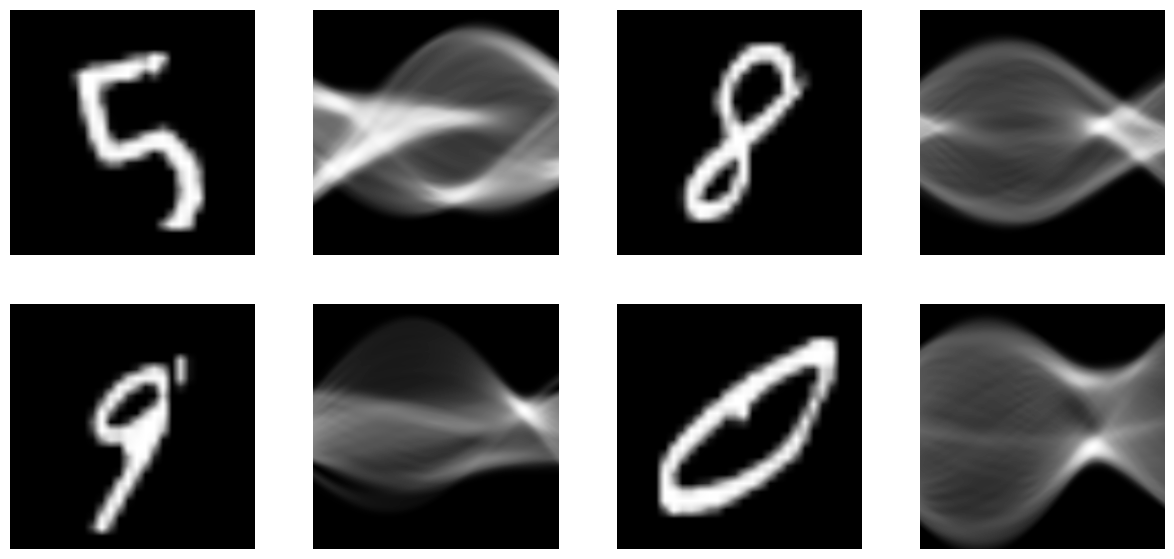

In [3]:
# code from https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html


fig, ax = plt.subplots(2, 4, figsize=(15, 7))
nP=256
imageInex=[1024, 1025, 1027,  1029]
for i in imageInex:
  image=x_train[i,:,:]
  image = resize(image, (nP,nP), mode='edge')
  plt.subplot(2,4,2*imageInex.index(i)+1)
  plt.imshow(image, cmap=plt.cm.Greys_r)
  plt.axis('off')
  theta = np.linspace(0., 180., max(image.shape), endpoint=False)
  sinogram = radon(image, theta=theta)
  dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
  plt.subplot(2,4,2*imageInex.index(i)+2)
  plt.imshow(sinogram, cmap=plt.cm.Greys_r)
  plt.axis('off')

plt.savefig('mnistSinograms.pdf')
#files.download('mnistSinograms.pdf')


## Explicit convolution backprojection example

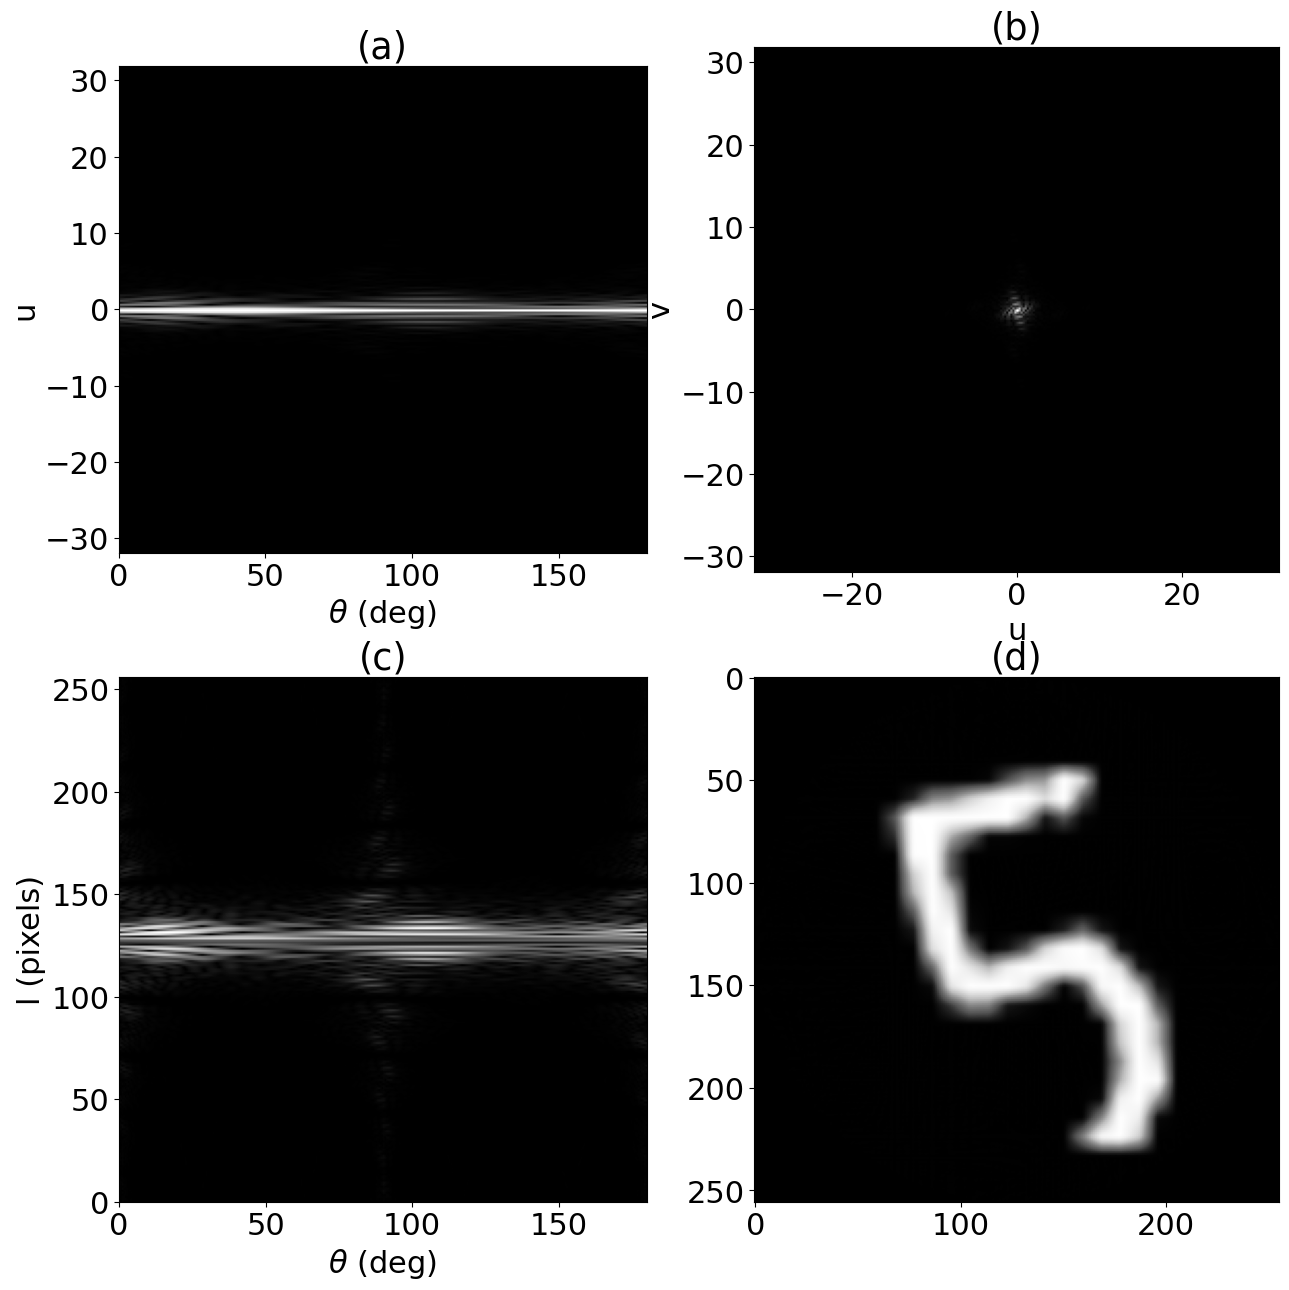

In [4]:
xMax=2;
nP=256;
xStep=2*xMax/(nP-1);
uMax=1/(2*xStep);uStep=2*uMax/(nP-1);
urange=np.linspace(-uMax,uMax,nP);
xrange=np.linspace(-xMax,xMax,nP);
thetaRange=np.arange(0,180,.5);
[x,y]=np.meshgrid(xrange,xrange);
[v,u]=np.meshgrid(thetaRange,urange);
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
image=x_train[1024,:,:]
image = resize(image, (nP,nP), mode='edge')
rTf1=radon(image,thetaRange);
ftR=np.fft.fftshift(np.fft.fft(np.fft.fftshift(rTf1,axes=0),axis=0),axes=0);
Q=np.fft.fftshift(np.fft.fft(np.fft.fftshift(ftR*u,axes=0),axis=0),axes=0);
ax[0,0].imshow(np.abs(ftR), cmap=plt.cm.Greys_r, extent = (0 , 180,-uMax  ,uMax) );
ax[0,0].set_title('(a)')
ax[0,0].set_xlabel(r'$\theta$ (deg)')
ax[0,0].set_ylabel("u")
ax[0,0].set_aspect(2.6)
ax[0,1].imshow(abs(np.fft.fftshift(np.fft.fft2(image))),cmap=plt.cm.Greys_r,extent = (-uMax,uMax,-uMax,uMax));
ax[0,1].set_title('(b)')
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("u")
ax[0,1].set_ylabel("v")
recon= iradon(rTf1,theta=thetaRange)
ax[1,0].imshow(np.transpose(np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.transpose(Q), axes=1)),axes=1))),cmap=plt.cm.Greys_r,extent=[0 , 180, 0  ,256]);
ax[1,0].set_aspect(.7)
ax[1,0].set_title('(c)')
ax[1,0].set_xlabel(r"$\theta$ (deg)")
ax[1,0].set_ylabel("l (pixels)")
ax[1,1].imshow(recon,cmap=plt.cm.Greys_r);
ax[1,1].set_title('(d)')
plt.savefig('mnistRadon.pdf')
#files.download('mnistRadon.pdf')


## Algebraic Reconstruction from Sparse Data

SART (1 iteration) rms reconstruction error: 0.13
SART (1 iteration) rms reconstruction error: 0.115


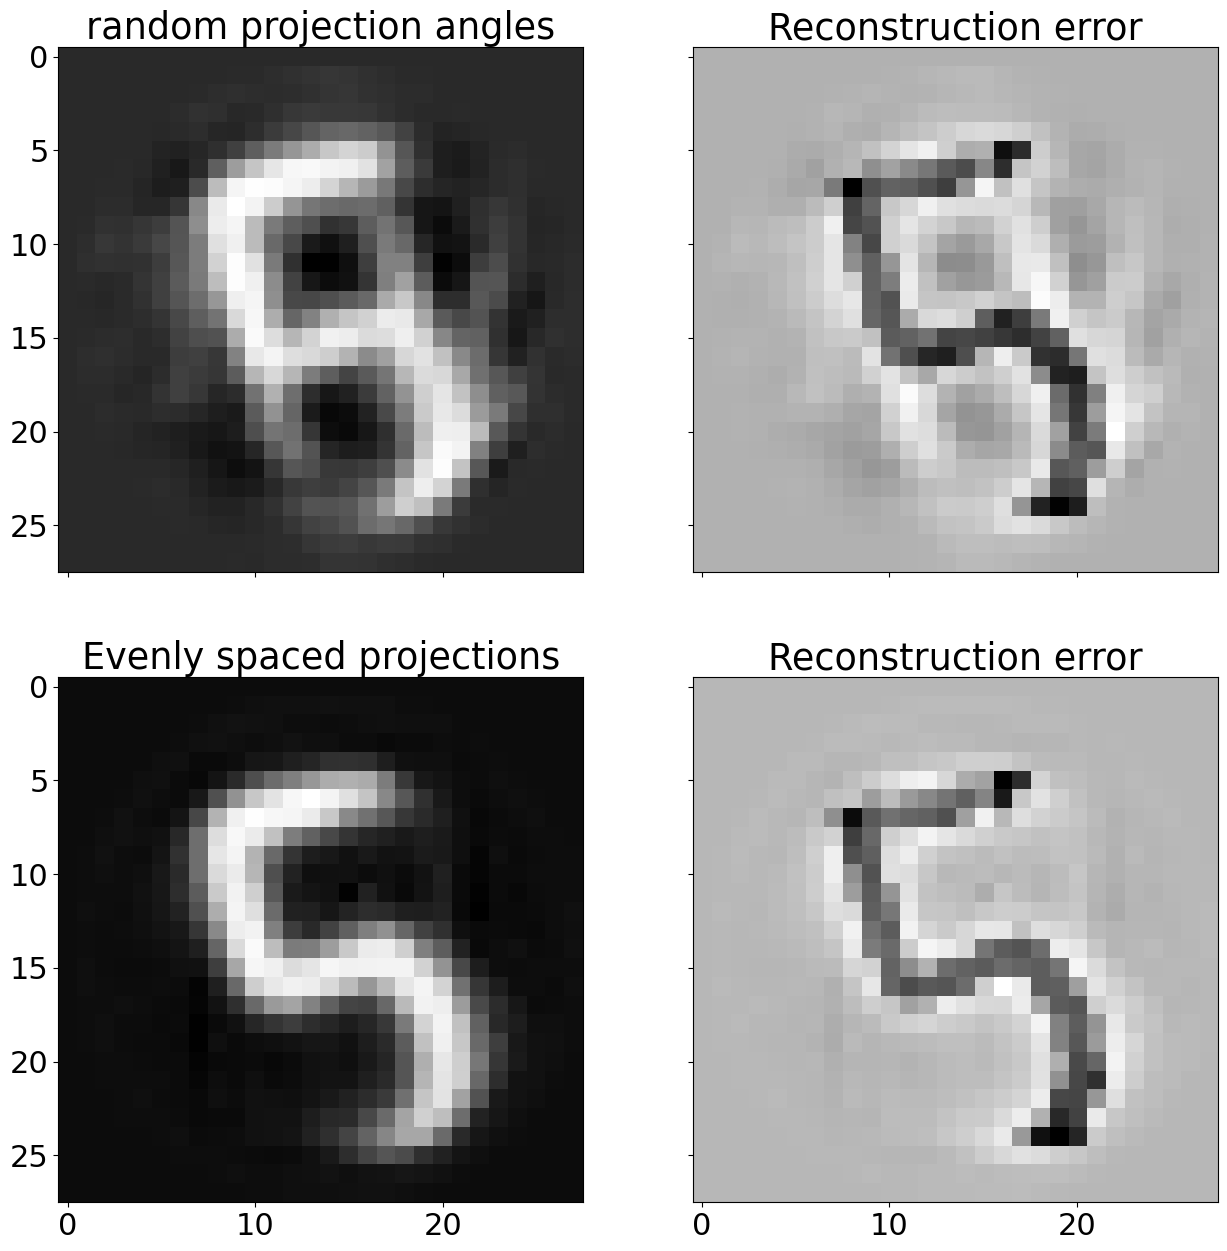

In [ ]:


ntheta=20;
image=x_train[1024,:,:]
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("random projection angles")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)
# no try with regularly spaced samples
thetaVals=np.linspace(0,180,ntheta)
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Evenly spaced projections")
ax[2].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error")
ax[3].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)


# Neural compressed sensing

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.


(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

1.0


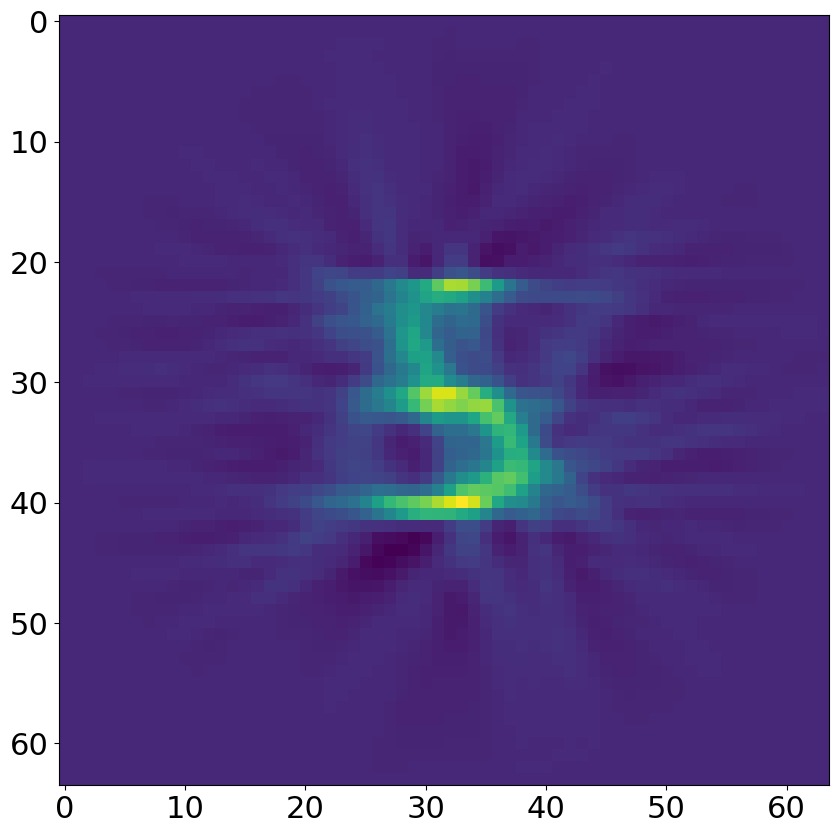

In [ ]:
plt.imshow(g_test[1931].reshape(64, 64))
print(np.max(g_test[1931]))

### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                   

2024-07-29 17:05:36.066137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-29 17:05:36.240142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dbrady/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64
2024-07-29 17:05:36.240169: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-29 17:05:36.241190: I t

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 51s 107ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 2/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0011 - val_loss: 9.6674e-04
Epoch 4/10
469/469 [==============================] - 50s 106ms/step - loss: 9.0594e-04 - val_loss: 8.1360e-04
Epoch 5/10
469/469 [==============================] - 49s 105ms/step - loss: 8.0972e-04 - val_loss: 7.8314e-04
Epoch 6/10
469/469 [==============================] - 50s 106ms/step - loss: 7.3745e-04 - val_loss: 6.9760e-04
Epoch 7/10
469/469 [==============================] - 50s 106ms/step - loss: 6.8377e-04 - val_loss: 6.6708e-04
Epoch 8/10
469/469 [==============================] - 50s 106ms/step - loss: 6.4251e-04 - val_loss: 6.0749e-04
Epoch 9/10
469/469 [==============================] - 50s 106ms/step - loss: 6.1122e-04 - val_loss: 5.6845e-04
Epoch 10/10
469/469 [

### Examples of subsampled and estimated images

1/1 [==============================] - 0s 12ms/step


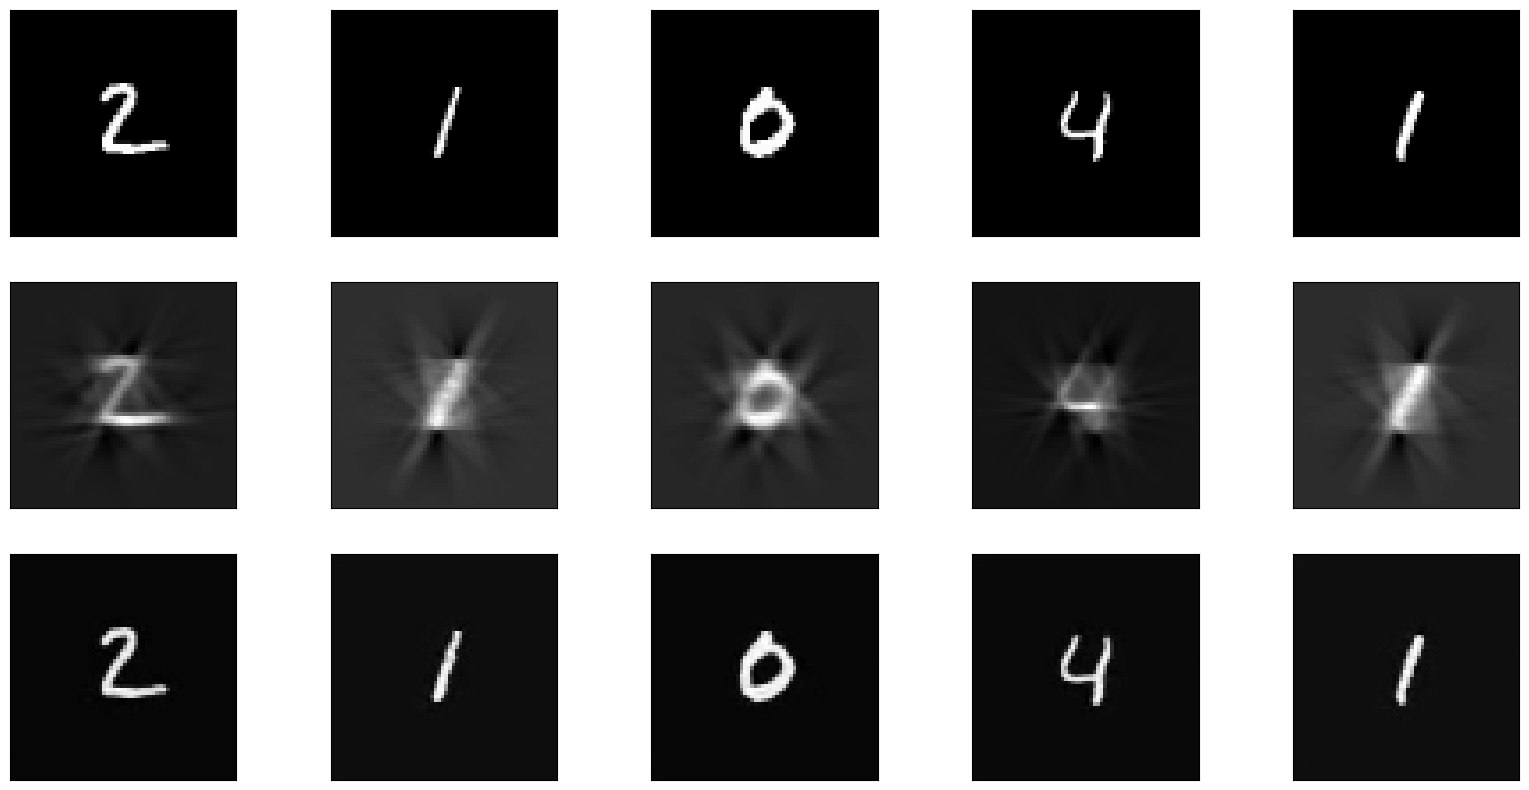

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompression.pdf')
#files.download('subSampleSARTNeuralDecompression.pdf')

# Neural compressed sensing with noise

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
#
# we are going to add poisson noise to the measurements. nPhoto is an gain factor for the intensity of the measured signal
#
nPhoto=1

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                 

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 51s 107ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 2/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 9/10
469/469 [==============================] - 50s 106ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/10
469/469 [==============================] - 50s 106ms/step - l

### Examples of subsampled and estimated images

1/1 [==============================] - 0s 11ms/step


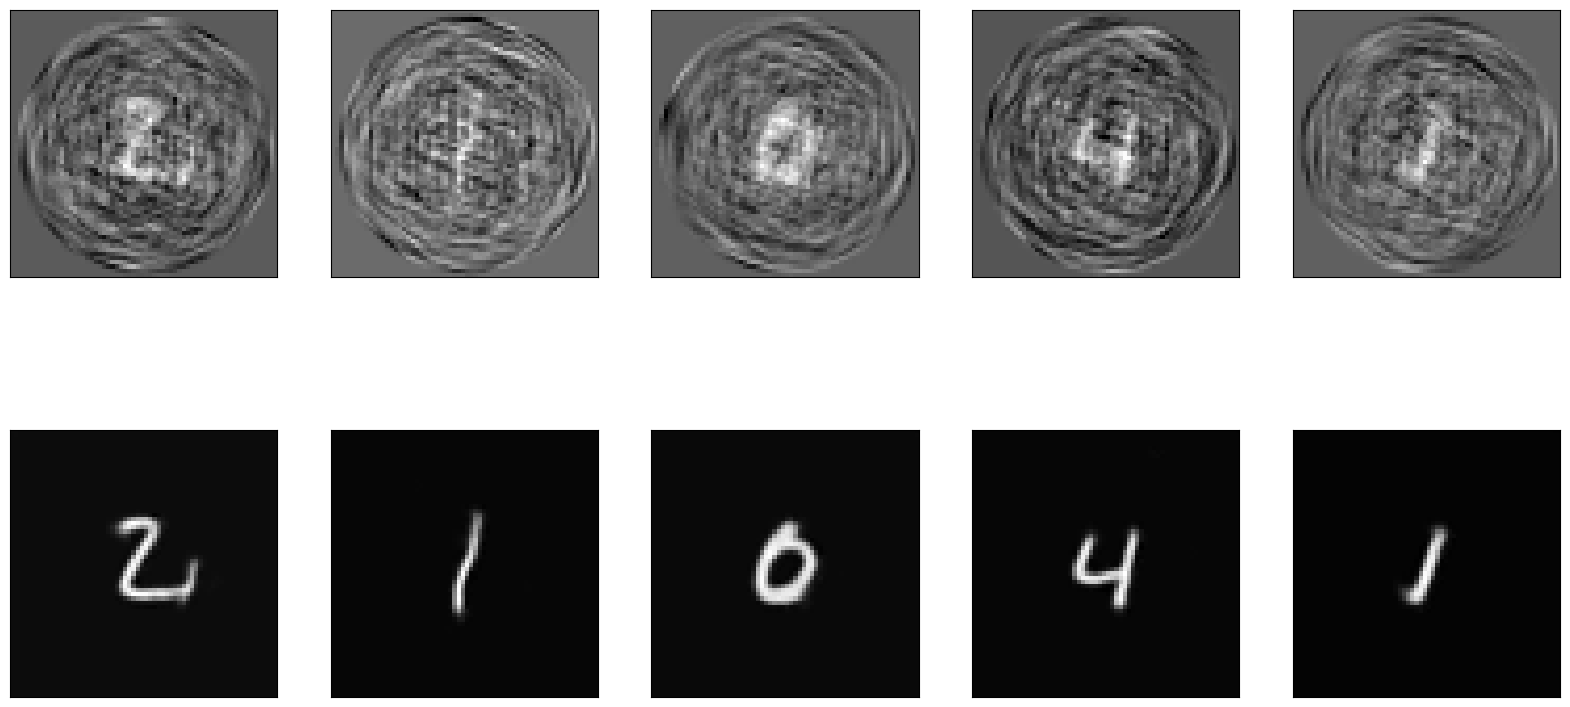

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompressionNoise20.pdf')
#files.download('subSampleSARTNeuralDecompressionNoise20.pdf')

# Neural fully sampled with noise

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20*9;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
#
# we are going to add poisson noise to the measurements. nPhoto is an gain factor for the intensity of the measured signal
#
nPhoto=1/9

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 64, 64, 32)       18464     
 Transpose)                                                

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 51s 107ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 2/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 3/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 4/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 5/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
469/469 [==============================] - 50s 107ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
469/469 [==============================] - 50s 107ms/step - l

### Examples of subsampled and estimated images

1/1 [==============================] - 0s 10ms/step


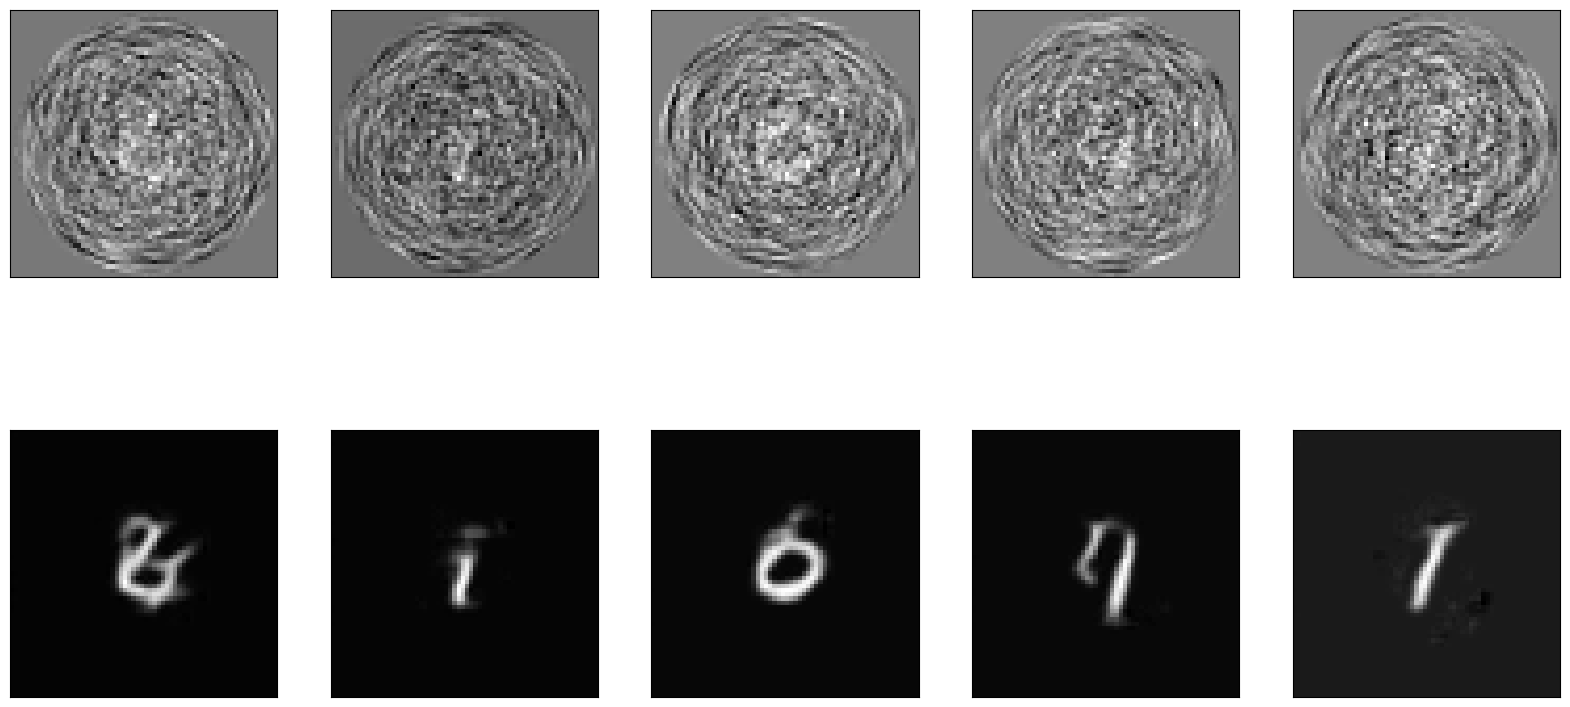

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompressionNoisefull.pdf')
#files.download('subSampleSARTNeuralDecompressionNoisefull.pdf')